In [7]:
import os
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.cross_validation import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:

images = []


ff = glob.glob(r"C:\Users\pruthvi\Desktop\009Longitudinal_prediction\Example_MRI_Data\*")
for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_data()
    a = a[:,78:129,:]
    for i in range(a.shape[1]):
        images.append((a[:,i,:]))
print (a.shape)

images = np.asarray(images)
images = images.reshape(-1, 256,320,1)
m = np.max(images)
mi = np.min(images)
images = (images - mi) / (m - mi)


from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,images,test_size=0.2,random_state=13)

batch_size = 30
epochs = 50
inChannel = 1
x, y = 256, 320
input_img = Input(shape = (x, y, inChannel))



(256, 51, 320)


In [9]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [10]:
autoencoder = Model(input_img, autoencoder(input_img))


In [11]:
autoencoder.load_weights('autoencoder_mri.h5')


In [12]:
pred = autoencoder.predict(valid_X,batch_size=1)


Test Images


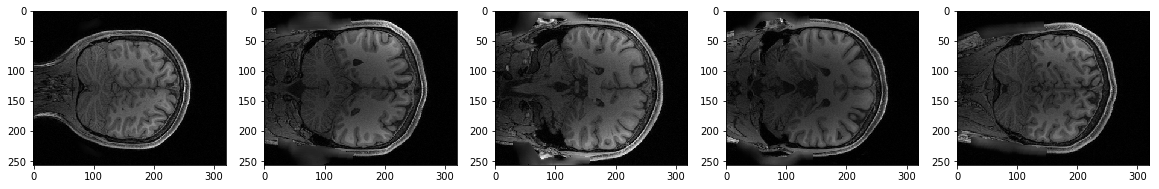

Reconstruction of Test Images


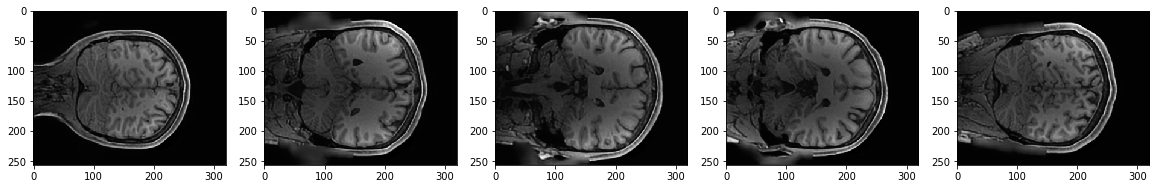

In [13]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
[a,b,c,d]= np.shape(valid_X)
mean = 0
sigma = 0.03
gauss = np.random.normal(mean,sigma,(a,b,c,d))
noisy_images = valid_X + gauss

In [9]:
pred_noisy = autoencoder.predict(noisy_images,batch_size=1)


Noisy Test Images


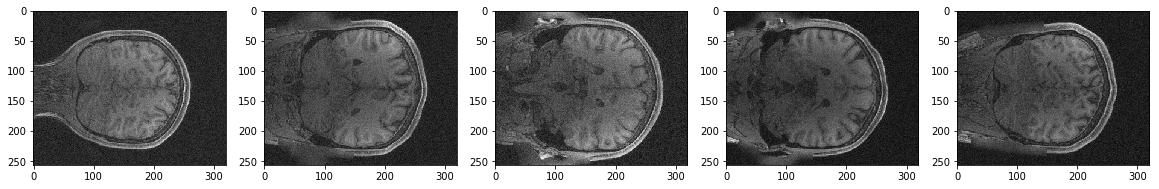

Reconstruction of Noisy Test Images


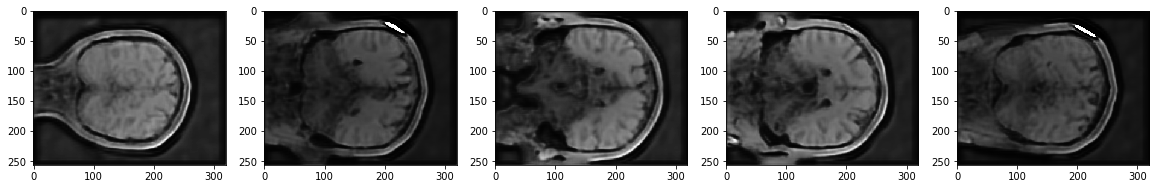

In [10]:
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(noisy_images[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred_noisy[i, ..., 0], cmap='gray')  
plt.show()